In [77]:
from geopandas.tools import sjoin
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import sys

wor_dir="/home/fbf/"
wor_dir='C:/Typhoon_IBF/Typhoon-Impact-based-forecasting-model/IBF-Typhoon-model/'
os.chdir(wor_dir)


### Source for pre disaster indicators: https://data.humdata.org/dataset/philippines-pre-disaster-indicators

In [146]:
file_name = "data/pre_disaster_indicators/190108_pantawid-pamilya-beneficiary-households-and-household-members-by-sex-and-age-group.xlsx"

path = os.path.join(wor_dir, file_name)

pantawid_pamilya_beneficiary = pd.read_excel(path, sheet_name="Data", engine="openpyxl").filter(['PCODE_MUN_CTY','Total # of Active HHs','Total HH MEM_M','Total HH MEM_F'])
#pantawid_pamilya_beneficiary['Municipality_City Code']=pantawid_pamilya_beneficiary['PCODE_MUN_CTY']

pantawid_pamilya_beneficiary.rename(columns={"PCODE_MUN_CTY": "Mun_Code"},inplace=True)
pantawid_pamilya_beneficiary['pantawid_total_pop']=pantawid_pamilya_beneficiary["Total HH MEM_M"]+pantawid_pamilya_beneficiary["Total HH MEM_F"]
pantawid_pamilya_beneficiary =  pantawid_pamilya_beneficiary.filter(['Mun_Code','Total # of Active HHs','pantawid_total_pop'])
display(pantawid_pamilya_beneficiary.head())
 

 


,Mun_Code,Total # of Active HHs,pantawid_total_pop
0,PH133902000,101,540
1,PH133908000,201,895
2,PH133909000,252,1303
3,PH133910000,989,5810
4,PH133911000,1038,5859


### population per admin 

In [147]:
file_name = "data/pre_disaster_indicators/180814_philippines-population-admin-1-to-3_2015_vertical.xlsx"

path = os.path.join(wor_dir, file_name)

population_admin = pd.read_excel(path, sheet_name="Municipality", engine="openpyxl").filter(['Municipality_City Code','Female','Male']).groupby('Municipality_City Code').agg('sum')

population_admin['Total Pop']=population_admin.sum(axis="columns") 
population_admin['Mun_Code']=population_admin.index.tolist()

population_admin.reset_index(drop=True, inplace=True)

#population_admin.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
display(population_admin.head())

,Female,Male,Total Pop,Mun_Code
0,825,967,1792,PH012801000
1,16175,16040,32215,PH012802000
2,15564,16052,31616,PH012803000
3,7422,7250,14672,PH012804000
4,27695,27506,55201,PH012805000


### vulnerable Groups

In [148]:
file_name = "data/pre_disaster_indicators/180814_vulnerable-groups_by-city_municipality.xlsx"

path = os.path.join(wor_dir, file_name)

vulnerable_groups = pd.read_excel(path, sheet_name="Data", engine="openpyxl")

vulnerable_groups['vulnerable_groups']=vulnerable_groups.sum(axis="columns")
vulnerable_groups=vulnerable_groups.filter(['Municipality_City Code','vulnerable_groups'])
vulnerable_groups.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
display(vulnerable_groups.head())

C:\Users\ATEKLE~1\AppData\Local\Temp/ipykernel_24260/2895691635.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vulnerable_groups['vulnerable_groups']=vulnerable_groups.sum(axis="columns")


,Mun_Code,vulnerable_groups
0,PH012801000,44
1,PH012802000,173
2,PH012803000,461
3,PH012804000,164
4,PH012805000,334


### housing material

In [149]:
file_name = "data/pre_disaster_indicators/180814_construction-materials-of-the-outer-walls-and-roof_by-city_municipality.xlsx"

path = os.path.join(wor_dir, file_name)

construction_materials = pd.read_excel(path, sheet_name="by category", engine="openpyxl")
construction_materials.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
construction_materials=construction_materials.filter(['Mun_Code', 'Housing Units','Strong Roof/Strong Wall', 'Strong Roof/Light Wall','Strong Roof/Salvage Wall', 'Light Roof/Strong Wall','Light Roof/Light Wall', 'Light Roof/Salvage Wall','Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall'])

df_cons_mat=construction_materials.iloc[:,2:].div(0.01*construction_materials["Housing Units"], axis=0)
df_cons_mat['Mun_Code']=construction_materials['Mun_Code']
df_cons_mat["Housing Units"]=construction_materials["Housing Units"]

display(df_cons_mat.head())


,Strong Roof/Strong Wall,Strong Roof/Light Wall,Strong Roof/Salvage Wall,Light Roof/Strong Wall,Light Roof/Light Wall,Light Roof/Salvage Wall,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,Mun_Code,Housing Units
0,17.226562,48.046875,0.000000,4.960938,29.570312,0.000000,0.000000,0.000000,0.000000,PH150708000,2560
1,13.792158,50.808884,0.027420,0.658075,34.357006,0.054840,0.000000,0.082259,0.000000,PH150709000,3647
2,33.706189,42.600502,0.162701,0.698258,21.991729,0.067792,0.040675,0.223714,0.155922,PH150702000,14751
3,18.565708,44.339279,0.254823,0.364033,36.075719,0.182017,0.000000,0.036403,0.036403,PH150710000,2747
4,8.849783,33.384341,0.127518,0.765111,56.490691,0.076511,0.000000,0.127518,0.153022,PH150712000,3921


In [97]:
#df_cm=construction_materials
#df_cm.rename(columns ={'Housing Units':'HUNITS', 'Strong Roof/Strong Wall':'SRSW','Strong Roof/Light Wall':'SRLW', 'Strong Roof/Salvage Wall':'SRSW','Light Roof/Strong Wall':'LRSW', 'Light Roof/Light Wall':'LRLW','Light Roof/Salvage Wall':'LRSW', 'Salvaged Roof/Strong Wall':'SRSW','Salvaged Roof/Light Wall':'SRLW', 'Salvaged Roof/Salvage Wall':'SRSW'},inplace=True)


In [7]:
len(construction_materials['Housing Units'])

1633

### Data on topography related variables 

In [150]:
geo_variable = pd.read_csv("data/topography/geo_variable.csv")
geo_variable=geo_variable.filter(['Mun_Code', 'mean_slope', 'mean_elevation_m','ruggedness_stdev', 'mean_ruggedness', 'slope_stdev', 'area_km2','poverty_perc', 'with_coast', 'coast_length', 'perimeter'])

display(geo_variable.head())

,Mun_Code,mean_slope,mean_elevation_m,ruggedness_stdev,mean_ruggedness,slope_stdev,area_km2,poverty_perc,with_coast,coast_length,perimeter
0,PH012801000,16.83,558.75,39.76,84.41,8.54,111,10.10,0,NaN,45998
1,PH012802000,2.13,23.80,12.14,12.05,2.49,55,2.07,1,4294.0,33314
2,PH012803000,7.37,97.70,39.58,37.37,8.27,81,4.99,1,15821.0,64986
3,PH012804000,11.94,220.47,41.11,59.74,8.83,115,3.75,1,11813.0,52052
4,PH012805000,5.23,91.41,23.81,27.49,5.18,158,3.22,0,NaN,66662


### Data for Land slide /storm surge vulnerable areas 

In [151]:
data_matrix_new_variables = pd.read_csv("data/landuse_stormsurge/data_matrix_new_variables.csv")
data_matrix_new_variables=data_matrix_new_variables.filter(['Mun_Code', 'landslide_per', 'stormsurge_per', 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg', 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 'Yellow_per_LSbl'])
display(data_matrix_new_variables.head())

,Mun_Code,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,RED_per_SSAbldg,OR_per_SSAbldg,Yellow_per_LSbl
0,PH012801000,4.08,0.00,0.00,4.08,4.08,0.0,0.00,0.00,0.00,0.00
1,PH012802000,1.41,1.54,1.54,1.41,0.00,0.0,1.41,1.48,0.03,0.03
2,PH012803000,2.45,1.68,1.68,2.45,0.04,0.0,2.40,1.64,0.00,0.04
3,PH012804000,2.88,1.51,1.51,2.88,0.41,0.0,2.47,1.44,0.00,0.07
4,PH012805000,0.03,0.03,0.03,0.03,0.03,0.0,0.00,0.00,0.00,0.03


### Impact Data(Damage and Loss data)

In [152]:

#df_total["perc_loss"] = df_total.apply(lambda x: division(x["area_affected"], x["rice_area"]), axis=1).values
impact = pd.read_csv("data/Impact/IMpact_data_philipines_SEP_2021.csv")
impact['typhoon']=impact["typhoon"].astype(str)  + impact["Year"].astype(str)
impact['typhoon']= impact['typhoon'].map(lambda x: x.lower())
impact.rename(columns={"pcode": "Mun_Code"},inplace=True)
typhoons_with_impact_data=list(np.unique(impact.typhoon))
#display(impact.head())
 
impact=impact[['Mun_Code','typhoon','Totally','Partially','total']]
df_impact=impact[['typhoon','Totally']].groupby('typhoon').sum().sort_values(by='Totally',ascending=False)#.head(n=10)

df_impact.reset_index(inplace=True)
df_impact['typhoon_name']=df_impact['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))

In [153]:
display(impact.head())

,Mun_Code,typhoon,Totally,Partially,total
0,PH041005000,durian2006,84.0,588.0,672.0
1,PH041006000,durian2006,1.0,7.0,8.0
2,PH041010000,durian2006,4.0,48.0,52.0
3,PH041014000,durian2006,0.0,78.0,78.0
4,PH041020000,durian2006,16.0,169.0,185.0


### number of Households per Manucipality 

In [154]:
file_name = "data/pre_disaster_indicators/180814_number-of-household_by-city_municipality.xlsx"

path = os.path.join(wor_dir, file_name)

household_by_city_municipality = pd.read_excel(path, sheet_name="Data", engine="openpyxl").filter(['Municipality_City','Municipality_City Code','Number of Household'])
household_by_city_municipality.rename(columns={"Municipality_City Code": "Mun_Code"},inplace=True)
household_by_city_municipality=household_by_city_municipality.filter(['Mun_Code','Number of Household'])
display(household_by_city_municipality.head())


,Mun_Code,Number of Household
0,PH012801000,411
1,PH012802000,8269
2,PH012803000,7375
3,PH012804000,3568
4,PH012805000,12797


### historical Typhoons Methadata (name, start date, end date, land fall)

In [142]:
typhoon_metadata_filename = os.path.join(wor_dir, "data/rainfall_data/input/metadata_typhoons.csv")
typhoon_metadata = pd.read_csv(typhoon_metadata_filename, delimiter=",")

typhoons = list(np.unique(impact.typhoon.values))# typhoon_metadata.typhoon.tolist() ## historical typhoon events 
municipalities=population_admin.Mun_Code.tolist() 

N_typh = len(typhoons)
N_mun = len(municipalities)

municipality_codes_full = np.repeat(municipalities, N_typh)
typhoons_full = typhoons * N_mun

In [155]:
pantawid_pamilya_beneficiary

,Mun_Code,Total # of Active HHs,pantawid_total_pop
0,PH133902000,101,540
1,PH133908000,201,895
2,PH133909000,252,1303
3,PH133910000,989,5810
4,PH133911000,1038,5859
...,...,...,...
1635,PH157004000,2407,11877
1636,PH157005000,2512,13821
1637,PH157006000,2261,12066
1638,PH157007000,2789,15477


### create data frame for all pre disaster indicators 

In [156]:
data_temp1 = {"Mun_Code": municipality_codes_full}#, "typhoon": typhoons_full}
df_temp_total = pd.DataFrame(data_temp1)

##data_matrix_new_variables
df_temp_total=df_temp_total.join(household_by_city_municipality.set_index('Mun_Code'), on='Mun_Code')

##data_matrix_new_variables
df_temp_total=df_temp_total.join(data_matrix_new_variables.set_index('Mun_Code'), on='Mun_Code')

#geo_variable
df_temp_total=df_temp_total.join(geo_variable.set_index('Mun_Code'), on='Mun_Code')
#construction_materials
df_temp_total=df_temp_total.join(df_cons_mat.set_index('Mun_Code'), on='Mun_Code')
#vulnerable_groups
df_temp_total=df_temp_total.join(vulnerable_groups.set_index('Mun_Code'), on='Mun_Code')
#population_admin
df_temp_total=df_temp_total.join(population_admin.set_index('Mun_Code'), on='Mun_Code')
#pantawid_pamilya_beneficiary
df_temp_total=df_temp_total.join(pantawid_pamilya_beneficiary.set_index('Mun_Code'), on='Mun_Code')

def housing(df):
    x=float(df[0])
    y=df[1]
    if np.isnan(y) and x>0:
        value=x
    elif np.isnan(y) and x<1:
        value=1
    else:
        value=y
    return value
df_temp_total["Housing Units"] = df_temp_total[['Number of Household','Housing Units']].apply(housing, axis="columns")
 
    
df_predisasters=df_temp_total#.set_index(['Mun_Code', 'typhoon'])


 

colnames=['landslide_per',
       'stormsurge_per', 'Bu_p_inSSA', 'Bu_p_LS', 'Red_per_LSbldg',
       'Or_per_LSblg', 'Yel_per_LSSAb', 'RED_per_SSAbldg', 'OR_per_SSAbldg',
       'Yellow_per_LSbl', 'mean_slope', 'mean_elevation_m', 'ruggedness_stdev',
       'mean_ruggedness', 'slope_stdev', 'area_km2', 'poverty_perc',
       'with_coast', 'coast_length', 'perimeter',
       'Strong Roof/Strong Wall', 'Strong Roof/Light Wall',
       'Strong Roof/Salvage Wall', 'Light Roof/Strong Wall',
       'Light Roof/Light Wall', 'Light Roof/Salvage Wall',
       'Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall',
       'Salvaged Roof/Salvage Wall', 'vulnerable_groups', 'Female', 'Male',
       'Total Pop', 'Total # of Active HHs', 'Total HH MEM_M',
       'Total HH MEM_F']

for column in df_predisasters:
    if column in colnames:
        df_predisasters[column].fillna((df_predisasters[column].min(skipna=True)), inplace=True)
        
        
display(df_predisasters.head())

,Mun_Code,Number of Household,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,RED_per_SSAbldg,...,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,Housing Units,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,pantawid_total_pop
0,PH012801000,411,4.08,0.00,0.00,4.08,4.08,0.0,0.00,0.00,...,0.000000,0.0,0.000000,411.0,44,825,967,1792,169.0,840.0
1,PH012802000,8269,1.41,1.54,1.54,1.41,0.00,0.0,1.41,1.48,...,0.012958,0.0,0.025917,7717.0,173,16175,16040,32215,643.0,3580.0
2,PH012803000,7375,2.45,1.68,1.68,2.45,0.04,0.0,2.40,1.64,...,0.000000,0.0,0.041929,7155.0,461,15564,16052,31616,1489.0,8338.0
3,PH012804000,3568,2.88,1.51,1.51,2.88,0.41,0.0,2.47,1.44,...,0.000000,0.0,0.000000,3534.0,164,7422,7250,14672,528.0,3022.0
4,PH012805000,12797,0.03,0.03,0.03,0.03,0.03,0.0,0.00,0.00,...,0.008098,0.0,0.000000,12348.0,334,27695,27506,55201,1697.0,9832.0


In [157]:
df_predisasters.columns

Index(['Mun_Code', 'Number of Household', 'landslide_per', 'stormsurge_per',
       'Bu_p_inSSA', 'Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg',
       'Yel_per_LSSAb', 'RED_per_SSAbldg', 'OR_per_SSAbldg', 'Yellow_per_LSbl',
       'mean_slope', 'mean_elevation_m', 'ruggedness_stdev', 'mean_ruggedness',
       'slope_stdev', 'area_km2', 'poverty_perc', 'with_coast', 'coast_length',
       'perimeter', 'Strong Roof/Strong Wall', 'Strong Roof/Light Wall',
       'Strong Roof/Salvage Wall', 'Light Roof/Strong Wall',
       'Light Roof/Light Wall', 'Light Roof/Salvage Wall',
       'Salvaged Roof/Strong Wall', 'Salvaged Roof/Light Wall',
       'Salvaged Roof/Salvage Wall', 'Housing Units', 'vulnerable_groups',
       'Female', 'Male', 'Total Pop', 'Total # of Active HHs',
       'pantawid_total_pop'],
      dtype='object')

In [75]:
df_predisasters

,Mun_Code,Number of Household,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,RED_per_SSAbldg,...,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F
0,PH012801000,411,4.08,0.00,0.00,4.08,4.08,0.0,0.00,0.00,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
1,PH012802000,8269,1.41,1.54,1.54,1.41,0.00,0.0,1.41,1.48,...,1.0,0.0,2.0,173,16175,16040,32215,643.0,1869.0,1711.0
2,PH012803000,7375,2.45,1.68,1.68,2.45,0.04,0.0,2.40,1.64,...,0.0,0.0,3.0,461,15564,16052,31616,1489.0,4444.0,3894.0
3,PH012804000,3568,2.88,1.51,1.51,2.88,0.41,0.0,2.47,1.44,...,0.0,0.0,0.0,164,7422,7250,14672,528.0,1579.0,1443.0
4,PH012805000,12797,0.03,0.03,0.03,0.03,0.03,0.0,0.00,0.00,...,1.0,0.0,0.0,334,27695,27506,55201,1697.0,5104.0,4728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,PH175913000,5055,3.54,2.11,2.11,3.54,1.58,0.0,1.96,2.11,...,9.0,27.0,4.0,700,11331,11940,23271,1553.0,5457.0,5210.0
1643,PH175914000,2392,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,1.0,438,5201,5680,10881,821.0,2717.0,2570.0
1644,PH175915000,3711,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,708,7873,8225,16098,1281.0,3736.0,3619.0
1645,PH175916000,1656,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,290,3457,3507,6964,497.0,1555.0,1400.0


### Add Typhoon wind Data

In [15]:
#Adding the wind data

data_temp1 = {"Mun_Code": municipality_codes_full, "typhoon": typhoons_full}
df_total = pd.DataFrame(data_temp1)

df_total["vmax"] = ""
df_total["dis_track_min"] = ""

df_wind_final= pd.DataFrame(columns=["typhoon", "Mun_Code", "v_max","dis_track_min"])

for typhoon in typhoons:

    # Path to the rainfall excel sheet per typhoon
    wind_path = os.path.join(
        wor_dir,
        "data/wind_data/output",
        typhoon +
        "_windgrid_output.csv",
    )
    df_temp = pd.read_csv(wind_path)
    
    df_wind_single = pd.DataFrame({"Mun_Code": df_temp["adm3_pcode"],"v_max": df_temp["v_max"],
                                   "dis_track_min": df_temp["dis_track_min"] })
    df_wind_single['typhoon']=typhoon
    df_wind_final = df_wind_final.append(df_wind_single) 


In [17]:
df_wind_final['typhoon_name']=df_wind_final['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_wind=df_wind_final[['typhoon_name','v_max']].groupby('typhoon_name').max().sort_values(by='v_max',ascending=False)#.head(n=10)
df_wind.reset_index(inplace=True)


### Add rainfall data

In [18]:
# Path to the rainfall excel sheet per typhoon
rain_path = os.path.join(wor_dir,"data/rainfall_data/rainfall_data.csv")
df_rain_final = pd.read_csv(rain_path)
df_rain_final=df_rain_final[df_rain_final.typhoon.isin(typhoons)]


### Merge rainfall and Wind data

In [19]:
df_hazard = pd.merge(df_rain_final, df_wind_final,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
#df_hazard=df_hazard[df_hazard['dis_track_min']<100]
display(df_hazard.head())  

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,dis_track_min,typhoon_name
0,durian2006,PH175301000,2.366667,0.138333,0.063472,NaN,NaN,NaN
1,durian2006,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,DURIAN-2006
2,durian2006,PH030801000,28.487500,1.893750,1.070833,23.402905,136.527982,DURIAN-2006
3,durian2006,PH021501000,127.362500,5.893750,3.504167,NaN,NaN,NaN
4,durian2006,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,DURIAN-2006


In [20]:
df_impact_hazard =pd.merge(df_hazard, impact,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
display(df_impact_hazard.head()) 

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,dis_track_min,typhoon_name,Totally,Partially,total
0,durian2006,PH175301000,2.366667,0.138333,0.063472,NaN,NaN,NaN,NaN,NaN,NaN
1,durian2006,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,DURIAN-2006,261.0,618.0,879.0
2,durian2006,PH030801000,28.487500,1.893750,1.070833,23.402905,136.527982,DURIAN-2006,NaN,NaN,NaN
3,durian2006,PH021501000,127.362500,5.893750,3.504167,NaN,NaN,NaN,NaN,NaN,NaN
4,durian2006,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,DURIAN-2006,NaN,NaN,NaN


In [21]:
df_impact_hazard[['typhoon','rainfall_Total','v_max','Totally', 'rainfall_max_6h',
       'rainfall_max_24h']].groupby('typhoon').agg(rainfall_Total=('rainfall_Total', max), 
                                                   rainfall_max_6h=('rainfall_max_6h', max), 
                                                    rainfall_max_24h=('rainfall_max_24h', max), 
                                                   v_max=('v_max', max), 
                                                   Totally=('Totally', sum)).sort_values(by='rainfall_Total',ascending=False)


,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,Totally
typhoon,,,,,
melor2015,820.863636,51.534091,23.999702,67.048448,110036.0
trami2013,713.683333,44.991667,20.291915,2.727863,652.0
ketsana2009,669.756250,54.662500,21.964583,27.357624,30071.0
goni2015,644.866667,24.650000,17.143750,34.342125,184.0
lingling2014,566.415000,31.097500,17.352500,12.747879,1700.0
vamco2020,556.400000,42.656667,18.177917,56.412397,25750.0
koppu2015,544.400000,31.350000,18.308511,64.326178,18795.0
fengshen2008,542.900000,50.647917,19.032639,59.710869,79169.0
fung-wong2014,520.490000,25.445833,14.832979,19.994341,2842.0


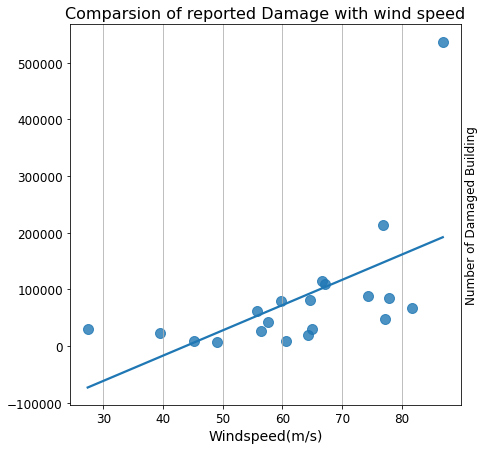

In [34]:
df_impact_hazard['typhoon_name']=df_impact_hazard['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_im_haz=df_impact_hazard[['typhoon_name','rainfall_Total','v_max','Totally']].groupby('typhoon_name').agg(rainfall_Total=('rainfall_Total', max), v_max=('v_max', max), Totally=('Totally', sum)).sort_values(by='Totally',ascending=False).head(n=20)
 
df_im_haz.rename(columns={"rainfall_Total": "Total Rainfall", "v_max": "Maximum Wind", "Totally": "Damaged Buildings"},inplace=True)

import matplotlib.pyplot as plt
import seaborn as sns
# Initialize the figure with a logarithmic x axis
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="linear", xscale="linear")

sns.regplot (y='Damaged Buildings', x='Maximum Wind', data=df_im_haz,scatter_kws={"s": 100},order=1,ci=0)  
# Plot the orbital period with horizontal boxes
#sns.relplot(y='Damaged Buildings', x='Maximum Wind', data=df_im_haz,palette="vlag")

# Add in points to show each observation
#sns.stripplot(y='Models', x='MAPE', data=df_im_haz,size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
#ax.set(ylabel="")
ax.set_title('Comparsion of reported Damage with wind speed',fontsize=16)
ax.set_xlabel('Windspeed(m/s)',fontsize=14)
ax.set_ylabel('Number of Damaged Building',fontsize=12)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#sns.despine(trim=True, left=True)
#f.savefig('algorithms_comparsion_mape.jpg', format='jpg', dpi=600)
ax.yaxis.set_label_position("right")
f.savefig('wind_BUILDINGDAMAGE.jpg', format='jpg', dpi=600)
#fig.savefig('Hazard_damage_comparsion.jpg', format='jpg', dpi=400)

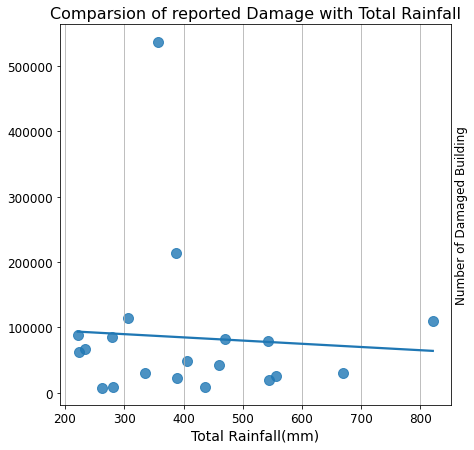

In [35]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="linear", xscale="linear")

sns.regplot (y='Damaged Buildings', x='Total Rainfall', data=df_im_haz,scatter_kws={"s": 100},order=1,ci=0)  
# Plot the orbital period with horizontal boxes
#sns.relplot(y='Damaged Buildings', x='Maximum Wind', data=df_im_haz,palette="vlag")

# Add in points to show each observation
#sns.stripplot(y='Models', x='MAPE', data=df_im_haz,size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
#ax.set(ylabel="")
ax.set_title('Comparsion of reported Damage with Total Rainfall',fontsize=16)
ax.set_xlabel('Total Rainfall(mm)',fontsize=14)
ax.set_ylabel('Number of Damaged Building',fontsize=12)
ax.yaxis.set_label_position("right")
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#sns.despine(trim=True, left=True)
f.savefig('RAIN_BUILDINGDAMAGE.jpg', format='jpg', dpi=600)


#fig.savefig('Hazard_damage_comparsion.jpg', format='jpg', dpi=400)


### Merge hazard(rainfall and Wind) data with Impac

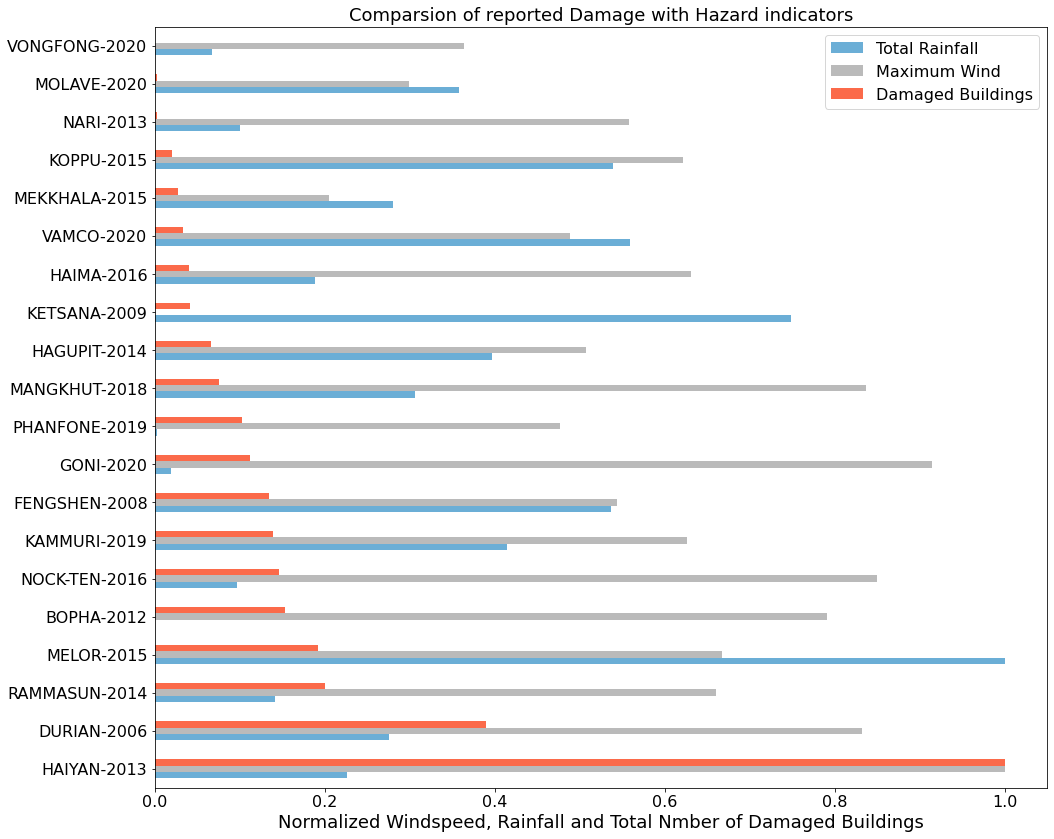

In [36]:
df_impact_hazard['typhoon_name']=df_impact_hazard['typhoon'].apply(lambda x:(x[:-4].upper()+'-'+x[-4:]))
 
df_im_haz=df_impact_hazard[['typhoon_name','rainfall_Total','v_max','Totally']].groupby('typhoon_name').agg(rainfall_Total=('rainfall_Total', max), v_max=('v_max', max), Totally=('Totally', sum)).sort_values(by='Totally',ascending=False).head(n=20)
 
def f(s):
    rmalized_df=(s-s.min())/(s.max()-s.min())
    return rmalized_df#s/s.max()

df_im_haz=df_im_haz[['rainfall_Total','v_max','Totally']].apply(f, axis=0)

df_im_haz.rename(columns={"rainfall_Total": "Total Rainfall", "v_max": "Maximum Wind", "Totally": "Damaged Buildings"},inplace=True)
df_im_haz
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(16, 14))

 
df_im_haz.plot(ax=ax,kind='barh',color=['#6baed6','#bababa','#fb6a4a'])

ax.set_title('Comparsion of reported Damage with Hazard indicators',fontsize=18)
ax.set_xlabel('Normalized Windspeed, Rainfall and Total Nmber of Damaged Buildings',fontsize=18)
ax.set_ylabel('',fontsize=14)


fig.savefig('Hazard_damage_comparsion.jpg', format='jpg', dpi=400)




#
    

In [37]:
df_total=pd.merge(df_impact_hazard, df_predisasters,  how='left', left_on=['Mun_Code', 'typhoon'], right_on = ['Mun_Code', 'typhoon'])
df_total=df_total[df_total['v_max'].notnull()]
df_total=df_total[df_total['rainfall_max_6h'].notnull()] 
#df_total=df_total[df_total['dis_track_min']<100]
display(df_total)

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,dis_track_min,typhoon_name,Totally,Partially,...,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F
1,durian2006,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,DURIAN-2006,261.0,618.0,...,0.0,2.0,6.0,924,15074,16232,31306,3372.0,9337.0,8671.0
2,durian2006,PH030801000,28.487500,1.893750,1.070833,23.402905,136.527982,DURIAN-2006,NaN,NaN,...,0.0,1.0,1.0,346,19779,20101,39880,830.0,2321.0,2164.0
4,durian2006,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,DURIAN-2006,NaN,NaN,...,4.0,12.0,15.0,1989,27840,31731,59571,3455.0,10000.0,8988.0
6,durian2006,PH045601000,193.083333,13.283333,7.378472,52.891105,41.386956,DURIAN-2006,NaN,NaN,...,0.0,0.0,3.0,251,6415,6436,12851,594.0,1823.0,1723.0
8,durian2006,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,DURIAN-2006,NaN,NaN,...,0.0,1.0,5.0,598,13808,14244,28052,2122.0,5613.0,5369.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66200,noul2015,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,NOUL-2015,NaN,NaN,...,0.0,3.0,1.0,211,9088,9419,18507,415.0,1325.0,1227.0
66201,noul2015,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,NOUL-2015,NaN,NaN,...,0.0,0.0,0.0,153,2631,2761,5392,232.0,743.0,637.0
66203,noul2015,PH012823000,42.227273,2.940152,0.864217,18.174500,154.588189,NOUL-2015,NaN,NaN,...,0.0,0.0,0.0,223,15850,16370,32220,907.0,2713.0,2504.0
66204,noul2015,PH051612000,32.305556,1.744444,1.210417,15.647639,219.542224,NOUL-2015,NaN,NaN,...,1.0,3.0,10.0,1095,21293,22192,43485,3047.0,9547.0,8654.0




###  Normalize data uisng population size or number of housing uints per manucipality (Calculate percentage per manucipality)

In [38]:

def division(x, y):
    try:
        value =100* (x / y)
        
    except:
        value = np.nan
    
    return 100 if value>100 else value


  

# Setting the new damage threshold

df_total["perc_dmg"] = df_total.apply(lambda x: division(x["Totally"], x["Housing Units"]), axis=1).values



df_total["vulnerable_groups"] = df_total.apply(lambda x: division(x["vulnerable_groups"], x["Total Pop"]), axis=1).values
#df_total["pantawid_pamilya_beneficiary"] = df_total.apply(lambda x: division(x["Total # of Active HHs"], x["Housing Units"]), axis=1).values
df_total["pantawid_pamilya_beneficiary"] = df_total.apply(lambda x: division(x["pantawid_total_pop"], x["Total Pop"]), axis=1).values
#df_total["Strong Roof/Strong Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Strong Wall"], x["Housing Units"]), axis=1).values
#df_total["Strong Roof/Light Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Light Wall"], x["Housing Units"]), axis=1).values
#df_total["Strong Roof/Salvage Wall"] = df_total.apply(lambda x: division(x["Strong Roof/Salvage Wall"], x["Housing Units"]), axis=1).values
#df_total["Light Roof/Strong Wall"] = df_total.apply(lambda x: division(x["Light Roof/Strong Wall"], x["Housing Units"]), axis=1).values
#df_total["Light Roof/Light Wall"] = df_total.apply(lambda x: division(x["Light Roof/Light Wall"], x["Housing Units"]), axis=1).values
##df_total["Light Roof/Salvage Wall"] = df_total.apply(lambda x: division(x["Light Roof/Salvage Wall"], x["Housing Units"]), axis=1).values
#df_total["Salvaged Roof/Strong Wall"] = df_total.apply(lambda x: division(x["Salvaged Roof/Strong Wall"], x["Housing Units"]), axis=1).values
#df_total["Salvaged Roof/Light Wall"] = df_total.apply(lambda x: division(x["Salvaged Roof/Light Wall"], x["Housing Units"]), axis=1).values
#df_total["Salvaged Roof/Salvage Wall"] = df_total.apply(lambda x: division(x["Salvaged Roof/Salvage Wall"], x["Housing Units"]), axis=1).values

display(df_total)

,typhoon,Mun_Code,rainfall_Total,rainfall_max_6h,rainfall_max_24h,v_max,dis_track_min,typhoon_name,Totally,Partially,...,Salvaged Roof/Salvage Wall,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F,perc_dmg,pantawid_pamilya_beneficiary
1,durian2006,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,DURIAN-2006,261.0,618.0,...,0.083507,2.951511,15074,16232,31306,3372.0,9337.0,8671.0,3.632568,46.931106
2,durian2006,PH030801000,28.487500,1.893750,1.070833,23.402905,136.527982,DURIAN-2006,NaN,NaN,...,0.010804,0.867603,19779,20101,39880,830.0,2321.0,2164.0,NaN,8.967156
4,durian2006,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,DURIAN-2006,NaN,NaN,...,0.112833,3.338873,27840,31731,59571,3455.0,10000.0,8988.0,NaN,25.989168
6,durian2006,PH045601000,193.083333,13.283333,7.378472,52.891105,41.386956,DURIAN-2006,NaN,NaN,...,0.095057,1.953155,6415,6436,12851,594.0,1823.0,1723.0,NaN,18.821293
8,durian2006,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,DURIAN-2006,NaN,NaN,...,0.075838,2.131755,13808,14244,28052,2122.0,5613.0,5369.0,NaN,32.185651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66200,noul2015,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,NOUL-2015,NaN,NaN,...,0.022528,1.140109,9088,9419,18507,415.0,1325.0,1227.0,NaN,9.348952
66201,noul2015,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,NOUL-2015,NaN,NaN,...,0.000000,2.837537,2631,2761,5392,232.0,743.0,637.0,NaN,21.928166
66203,noul2015,PH012823000,42.227273,2.940152,0.864217,18.174500,154.588189,NOUL-2015,NaN,NaN,...,0.000000,0.692117,15850,16370,32220,907.0,2713.0,2504.0,NaN,11.800677
66204,noul2015,PH051612000,32.305556,1.744444,1.210417,15.647639,219.542224,NOUL-2015,NaN,NaN,...,0.103821,2.518110,21293,22192,43485,3047.0,9547.0,8654.0,NaN,31.634136


### filter final data frame for only relevant features 

In [41]:
df_total=df_total.filter(['Mun_Code', 'typhoon', 'rainfall_Total', 'rainfall_max_6h',
                 'rainfall_max_24h', 'v_max', 'dis_track_min','landslide_per', 'stormsurge_per',
                 'Bu_p_inSSA','Bu_p_LS', 'Red_per_LSbldg', 'Or_per_LSblg',
                 'Yel_per_LSSAb','RED_per_SSAbldg', 'OR_per_SSAbldg', 
                 'Yellow_per_LSbl', 'mean_slope','mean_elevation_m', 
                 'ruggedness_stdev', 'mean_ruggedness','slope_stdev',
                 'poverty_perc', 'with_coast', 'coast_length','Housing Units', 'Strong Roof/Strong Wall',
                 'Strong Roof/Light Wall', 'Strong Roof/Salvage Wall',
                 'Light Roof/Strong Wall', 'Light Roof/Light Wall',
                 'Light Roof/Salvage Wall', 'Salvaged Roof/Strong Wall',
                 'Salvaged Roof/Light Wall', 'Salvaged Roof/Salvage Wall',
                 'vulnerable_groups', 'pantawid_pamilya_beneficiary','perc_dmg'])


df_total.rename(columns ={"rainfall_Total":"HAZ_rainfall_Total",
                                     'rainfall_max_6h':'HAZ_rainfall_max_6h',
                                     'rainfall_max_24h':'HAZ_rainfall_max_24h',
                                     'v_max':'HAZ_v_max',
                                     'dis_track_min':'HAZ_dis_track_min',
                                     'binary_dmg':'DAM_binary_dmg',
                                     'perc_dmg':'DAM_perc_dmg',
                                    'landslide_per':'GEN_landslide_per',
                                    'stormsurge_per':'GEN_stormsurge_per',
                                    'Bu_p_inSSA':'GEN_Bu_p_inSSA',
                                    'Bu_p_LS':'GEN_Bu_p_LS',
                                     'Red_per_LSbldg':'GEN_Red_per_LSbldg',
                                    'Or_per_LSblg':'GEN_Or_per_LSblg',
                                     'Yel_per_LSSAb':'GEN_Yel_per_LSSAb',
                                    'RED_per_SSAbldg':'GEN_RED_per_SSAbldg',
                                     'OR_per_SSAbldg':'GEN_OR_per_SSAbldg',
                                    'Yellow_per_LSbl':'GEN_Yellow_per_LSbl',
                                     'mean_slope':'TOP_mean_slope',
                                    'mean_elevation_m':'TOP_mean_elevation_m',
                                     'ruggedness_stdev':'TOP_ruggedness_stdev',
                                    'mean_ruggedness':'TOP_mean_ruggedness',
                                     'slope_stdev':'TOP_slope_stdev',
                                     'poverty_perc':'VUL_poverty_perc',
                                    'with_coast':'GEN_with_coast',
                                     'coast_length':'GEN_coast_length',
                                     'Housing Units':'VUL_Housing_Units',
                                    'Strong Roof/Strong Wall':"VUL_StrongRoof_StrongWall",
                                    'Strong Roof/Light Wall':'VUL_StrongRoof_LightWall',
                                    'Strong Roof/Salvage Wall':'VUL_StrongRoof_SalvageWall',
                                    'Light Roof/Strong Wall':'VUL_LightRoof_StrongWall',
                                    'Light Roof/Light Wall':'VUL_LightRoof_LightWall',
                                    'Light Roof/Salvage Wall':'VUL_LightRoof_SalvageWall',
                                    'Salvaged Roof/Strong Wall':'VUL_SalvagedRoof_StrongWall',
                                    'Salvaged Roof/Light Wall':'VUL_SalvagedRoof_LightWall',
                                    'Salvaged Roof/Salvage Wall':'VUL_SalvagedRoof_SalvageWall',
                                    'vulnerable_groups':'VUL_vulnerable_groups',
                                    'pantawid_pamilya_beneficiary':'VUL_pantawid_pamilya_beneficiary'},inplace=True)




In [44]:
selected_columns=['Mun_Code', 'typhoon', 'HAZ_rainfall_Total', 'HAZ_rainfall_max_6h',
'HAZ_rainfall_max_24h','HAZ_v_max', 'HAZ_dis_track_min','GEN_landslide_per', 'GEN_stormsurge_per',
'GEN_Bu_p_inSSA','GEN_Bu_p_LS', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg','GEN_Yel_per_LSSAb',
'GEN_RED_per_SSAbldg', 'GEN_OR_per_SSAbldg','GEN_Yellow_per_LSbl', 'TOP_mean_slope', 'TOP_mean_elevation_m',
'TOP_ruggedness_stdev', 'TOP_mean_ruggedness', 'TOP_slope_stdev','VUL_poverty_perc', 'GEN_with_coast',
'GEN_coast_length','VUL_Housing_Units', 'VUL_StrongRoof_StrongWall','VUL_StrongRoof_LightWall',
'VUL_StrongRoof_SalvageWall','VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall','VUL_LightRoof_SalvageWall',
'VUL_SalvagedRoof_StrongWall','VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall','VUL_vulnerable_groups',
'VUL_pantawid_pamilya_beneficiary','DAM_perc_dmg']



df_total = df_total.filter(selected_columns)
    

In [48]:
df_predisasters

,Mun_Code,typhoon,Number of Household,landslide_per,stormsurge_per,Bu_p_inSSA,Bu_p_LS,Red_per_LSbldg,Or_per_LSblg,Yel_per_LSSAb,...,Salvaged Roof/Strong Wall,Salvaged Roof/Light Wall,Salvaged Roof/Salvage Wall,vulnerable_groups,Female,Male,Total Pop,Total # of Active HHs,Total HH MEM_M,Total HH MEM_F
0,PH012801000,bopha2012,411,4.08,0.00,0.00,4.08,4.08,0.0,0.00,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
1,PH012801000,conson2010,411,4.08,0.00,0.00,4.08,4.08,0.0,0.00,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
2,PH012801000,durian2006,411,4.08,0.00,0.00,4.08,4.08,0.0,0.00,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
3,PH012801000,fengshen2008,411,4.08,0.00,0.00,4.08,4.08,0.0,0.00,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
4,PH012801000,fung-wong2014,411,4.08,0.00,0.00,4.08,4.08,0.0,0.00,...,0.0,0.0,0.0,44,825,967,1792,169.0,439.0,401.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65875,PH175917000,usagi2013,1880,4.81,0.52,0.52,4.81,0.34,0.0,4.47,...,9.0,7.0,19.0,273,4214,4294,8508,513.0,1698.0,1560.0
65876,PH175917000,utor2013,1880,4.81,0.52,0.52,4.81,0.34,0.0,4.47,...,9.0,7.0,19.0,273,4214,4294,8508,513.0,1698.0,1560.0
65877,PH175917000,vamco2020,1880,4.81,0.52,0.52,4.81,0.34,0.0,4.47,...,9.0,7.0,19.0,273,4214,4294,8508,513.0,1698.0,1560.0
65878,PH175917000,vongfong2020,1880,4.81,0.52,0.52,4.81,0.34,0.0,4.47,...,9.0,7.0,19.0,273,4214,4294,8508,513.0,1698.0,1560.0


### save final dataframe for model input

In [158]:
df_predisasters.to_csv("data/model_input/df_predisasters.csv", index=False)

In [28]:
np.mean(df_total["DAM_perc_dmg"])

4.3660026546786685

In [97]:
df_total=df_total[df_total["DAM_perc_dmg"].notnull()]

In [98]:
len(df_total)

4541

In [99]:
np.mean(df_total["DAM_perc_dmg"])

4.3660026546786685